# Прогнозирование температуры звезды

В рамках проекта необходимо придумать, как с помощью нейросети определять температуру на поверхности обнаруженных звёзд. Обычно для расчёта температуры учёные пользуются следующими методами:

    Закон смещения Вина.
    Закон Стефана-Больцмана.
    Спектральный анализ.

Каждый из них имеет плюсы и минусы. Обсерватория хочет внедрить технологии машинного обучения для предсказания температуры звёзд, надеясь, что этот метод будет наиболее точным и удобным.
В базе обсерватории есть характеристики уже изученных 240 звёзд.

<br>Необходимо разработать нейронную сеть, которая поможет предсказывать абсолютную температуру на поверхности звезды.

## Загрузка данных

In [2]:
import numpy as np
import pandas as pd   
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_squared_error
from phik import phik_matrix
from phik.report import plot_correlation_matrix
from math import ceil

import torch
import torch.nn as nn

In [3]:
# константы
RANDOM_STATE = 10

In [4]:
def about_df(list_df):
    '''выводит информацию о всех датасетах из списка list_df'''
    for c, i in enumerate(list_df):
        print("**** DATASET_"+str(c+1)+' ****')
        display(i.info())
        display(i.describe().round(2))
        print(f'Количество дубликатов: {i.duplicated().sum()}')
        print('Количество пропущенных значений:', i.isnull().sum(), sep='\n')
        print()

In [5]:
data = pd.read_csv('/datasets/6_class.csv')
data

,Unnamed: 0,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
0,0,3068,0.002400,0.1700,16.12,0,Red
1,1,3042,0.000500,0.1542,16.60,0,Red
2,2,2600,0.000300,0.1020,18.70,0,Red
3,3,2800,0.000200,0.1600,16.65,0,Red
4,4,1939,0.000138,0.1030,20.06,0,Red
...,...,...,...,...,...,...,...
235,235,38940,374830.000000,1356.0000,-9.93,5,Blue
236,236,30839,834042.000000,1194.0000,-10.63,5,Blue
237,237,8829,537493.000000,1423.0000,-10.73,5,White
238,238,9235,404940.000000,1112.0000,-11.23,5,White


In [6]:
about_df([data])

**** DATASET_1 ****
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              240 non-null    int64  
 1   Temperature (K)         240 non-null    int64  
 2   Luminosity(L/Lo)        240 non-null    float64
 3   Radius(R/Ro)            240 non-null    float64
 4   Absolute magnitude(Mv)  240 non-null    float64
 5   Star type               240 non-null    int64  
 6   Star color              240 non-null    object 
dtypes: float64(3), int64(3), object(1)
memory usage: 13.2+ KB


None

,Unnamed: 0,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type
count,240.00,240.00,240.00,240.00,240.00,240.00
mean,119.50,10497.46,107188.36,237.16,4.38,2.50
std,69.43,9552.43,179432.24,517.16,10.53,1.71
min,0.00,1939.00,0.00,0.01,-11.92,0.00
25%,59.75,3344.25,0.00,0.10,-6.23,1.00
50%,119.50,5776.00,0.07,0.76,8.31,2.50
75%,179.25,15055.50,198050.00,42.75,13.70,4.00
max,239.00,40000.00,849420.00,1948.50,20.06,5.00


Количество дубликатов: 0
Количество пропущенных значений:
Unnamed: 0                0
Temperature (K)           0
Luminosity(L/Lo)          0
Radius(R/Ro)              0
Absolute magnitude(Mv)    0
Star type                 0
Star color                0
dtype: int64



**Вывод** 
<br> Датасет содержит данные о 240 звездах. Пропуски / дубликаты отсутсвуют. Названия колонок не соответствуют стандарту. Имеется колонка "Unnamed: 0", которая по сути копия индекса (будет удалена в следующем разделе). Датасет занимает всего 13.2 кб.

## Предобработка и анализ данных

In [7]:
# удалим колонку "Unnamed: 0"
data = data.drop("Unnamed: 0", axis=1)
data

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
0,3068,0.002400,0.1700,16.12,0,Red
1,3042,0.000500,0.1542,16.60,0,Red
2,2600,0.000300,0.1020,18.70,0,Red
3,2800,0.000200,0.1600,16.65,0,Red
4,1939,0.000138,0.1030,20.06,0,Red
...,...,...,...,...,...,...
235,38940,374830.000000,1356.0000,-9.93,5,Blue
236,30839,834042.000000,1194.0000,-10.63,5,Blue
237,8829,537493.000000,1423.0000,-10.73,5,White
238,9235,404940.000000,1112.0000,-11.23,5,White


In [8]:
# переименуем назавания колонок
data.columns = ['temperature', 'luminosity', 'radius', 
                'absolute_magnitude', 'star_type', 'star_color']
data.head(1)

,temperature,luminosity,radius,absolute_magnitude,star_type,star_color
0,3068,0.0024,0.17,16.12,0,Red


Проведем краткий EDA

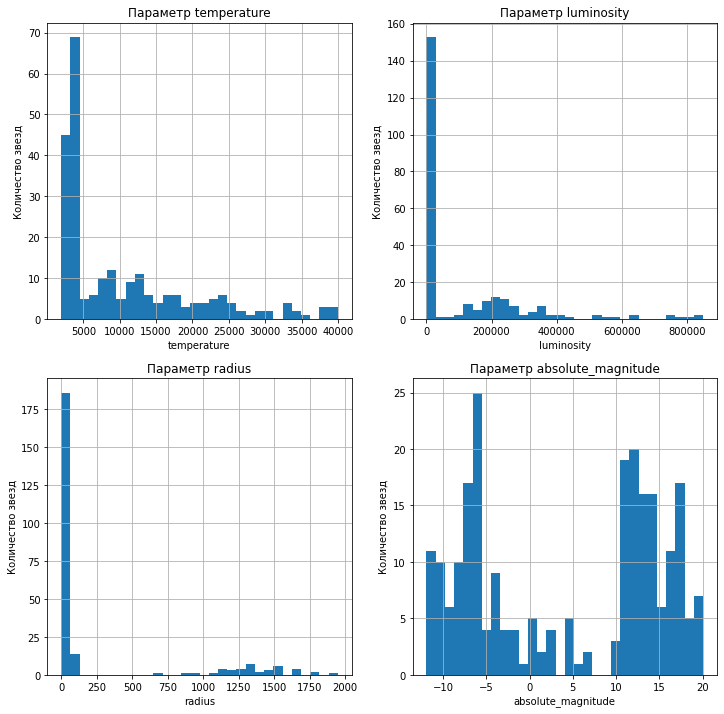

In [9]:
# распределение звезд по количественным признакам
temp = ['temperature', 'luminosity', 'radius', 'absolute_magnitude']
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axe = axes.ravel()
for i, c in enumerate(temp):
    data[c].hist(bins=30, ax =axe[i])
    axe[i].set_title(f'Параметр {c}')
    axe[i].set_xlabel(c)
    axe[i].set_ylabel('Количество звезд')
plt.show()

In [10]:
# посмотрим на цвет звезд
data.star_color.unique()

array(['Red', 'Blue White', 'White', 'Yellowish White', 'Blue white',
       'Pale yellow orange', 'Blue', 'Blue-white', 'Whitish',
       'yellow-white', 'Orange', 'White-Yellow', 'white', 'Blue ',
       'yellowish', 'Yellowish', 'Orange-Red', 'Blue white ',
       'Blue-White'], dtype=object)

In [11]:
# изменим регистр, удалим пробелы справа и заменим пробел на "-"
data['star_color'] = data['star_color'].str.lower().str.rstrip().str.replace(' ', '-')

In [12]:
data.star_color.unique()

array(['red', 'blue-white', 'white', 'yellowish-white',
       'pale-yellow-orange', 'blue', 'whitish', 'yellow-white', 'orange',
       'white-yellow', 'yellowish', 'orange-red'], dtype=object)

In [13]:
temp = data.groupby('star_color')['temperature'].count()
temp

star_color
blue                   56
blue-white             41
orange                  2
orange-red              1
pale-yellow-orange      1
red                   112
white                  10
white-yellow            1
whitish                 2
yellow-white            8
yellowish               3
yellowish-white         3
Name: temperature, dtype: int64

Категорий цвета всего 7. В датасете больше. Посмотрим, какая температура у прочих категорий и изменим цвет согласно температуре ближайшей категорри из названия.

In [14]:
data.query('star_color == "orange-red" | star_color == "pale-yellow-orange" | \
            star_color == "white-yellow" | star_color == "yellowish-white"')

,temperature,luminosity,radius,absolute_magnitude,star_type,star_color
25,12990,0.000085,0.00984,12.23,2,yellowish-white
27,7700,0.000110,0.01280,14.47,2,yellowish-white
28,11790,0.000150,0.01100,12.59,2,yellowish-white
29,7230,0.000080,0.01300,14.08,2,pale-yellow-orange
80,7100,0.000290,0.01200,14.09,2,white-yellow
96,5112,0.630000,0.87600,4.68,3,orange-red


In [15]:
# заменим цвета звезд
data['star_color'] = data['star_color'].replace('whitish', 'white')\
                                       .replace('orange-red', 'orange')\
                                       .replace('yellowish-white', 'white')\
                                       .replace('pale-yellow-orange', 'white-yellow')\
                                       .replace('yellowish-white', 'white-yellow')\
                                       .replace('yellow-white', 'white-yellow')

In [16]:
# КОД РЕВЬЮЕРА
data['star_color'] = data['star_color'].replace('whitish', 'white')\
                                       .replace('orange-red', 'orange')\
                                       .replace('yellowish-white', 'white-yellow')\
                                       .replace('pale-yellow-orange', 'orange')\
                                       .replace('yellowish-white', 'white-yellow')\
                                       .replace('yellow-white', 'white-yellow')

In [17]:
temp = data.groupby('star_color')['temperature'].count()
temp

star_color
blue             56
blue-white       41
orange            3
red             112
white            15
white-yellow     10
yellowish         3
Name: temperature, dtype: int64

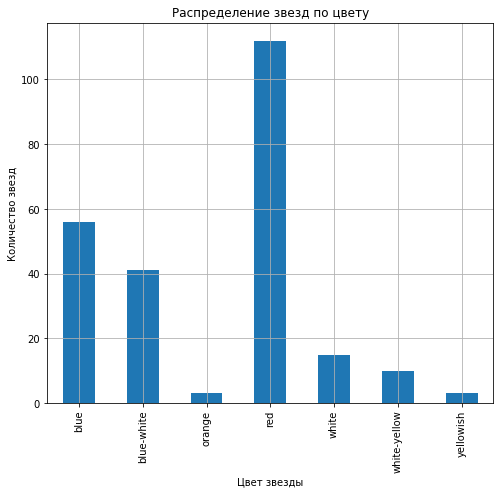

In [18]:
temp.plot(
    kind='bar', grid=True, figsize=(8, 7),
    title='Распределение звезд по цвету',
    xlabel='Цвет звезды',
    ylabel='Количество звезд'
);

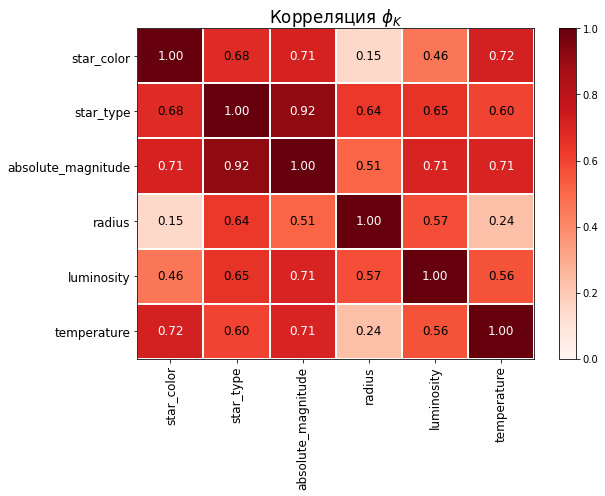

In [19]:
# расчет корреляции 
interval_cols = list(data._get_numeric_data().columns)
phik_overview = data.phik_matrix(interval_cols=interval_cols)

# heatmap
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Reds',
    title=r'Корреляция $\phi_K$',
    fontsize_factor=1.2,
    figsize=(9, 7)
) 

In [20]:
data.head(2)

,temperature,luminosity,radius,absolute_magnitude,star_type,star_color
0,3068,0.0024,0.1700,16.12,0,red
1,3042,0.0005,0.1542,16.60,0,red


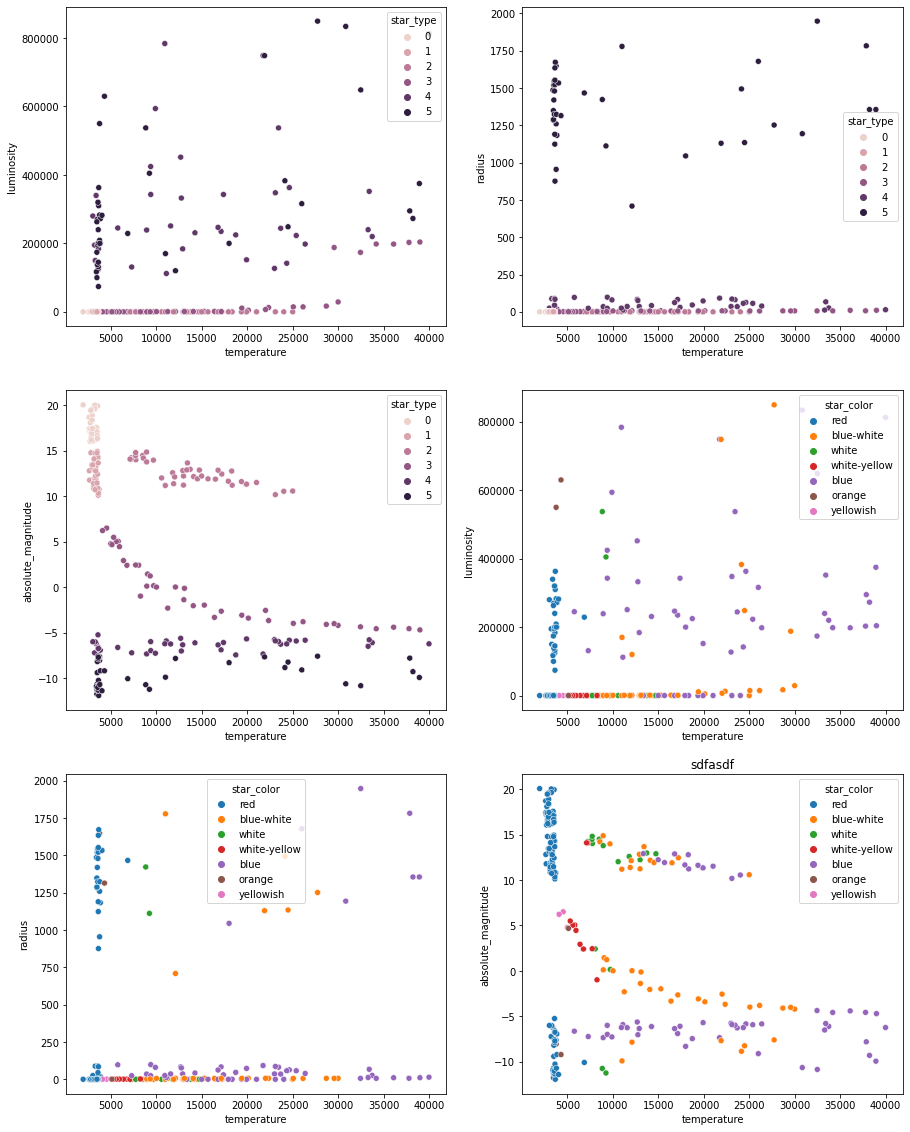

In [21]:
numeric = ['luminosity', 'radius', 'absolute_magnitude']
categorial = ['star_type', 'star_color']
fig, axes = plt.subplots(3, 2, figsize=(15, 20))
axe = axes.ravel()

for i, c in enumerate(numeric):
        sns.scatterplot(data=data, x='temperature', y=c, hue='star_type', ax=axe[i])
for i, c in enumerate(numeric):
        sns.scatterplot(data=data, x='temperature', y=c, hue='star_color', ax=axe[i+3])
        
plt.title('sdfasdf');

**Вывод**
<br> Как видно, большинство звезд имеют температуру до 5000 К, а также довольно малую светимость и радиус относительно Солнца(< 1).
Большинство звезд имеют красный, голубой и голубовато-белый цвет. Ввиду малого количества данных (всего 240 наблюдений) аномально высокие и низкие значения были оставлены. Наиболее сильно на температуру звезды влияют ее цвет и абсолютная звёздная величина. Из диаграмм рассеяния видно, что абсолютная звёздная величина мало влияет на температуру звезды.

## Подготовка данных к построению модели

In [22]:
# разделим данные на тестовую и тренировочную выборки
X_train, X_test, y_train, y_test = train_test_split(data.drop('temperature', axis=1), 
                                                    data['temperature'], 
                                                    test_size=0.2, 
                                                    shuffle=True,
                                                    random_state=RANDOM_STATE)

In [23]:
# выделим категориальные и численные столбцы
num_cols = ['luminosity', 'radius', 'absolute_magnitude']
cat_cols = ['star_type', 'star_color']

In [24]:
col_transformer = ColumnTransformer(
                        transformers=[
                            ('scaler', StandardScaler(), num_cols),
                            ('ohe', OneHotEncoder(sparse=False), cat_cols)],
                                remainder='passthrough'
                                  )

col_transformer.fit(X_train)
X_train = col_transformer.transform(X_train)
X_test = col_transformer.transform(X_test)

## Построение базовой нейронной сети

In [25]:
# Переведём выборки в тензоры
X_train = torch.FloatTensor(np.array(X_train))
X_test = torch.FloatTensor(np.array(X_test))
y_train = torch.FloatTensor(np.array(y_train))
y_test = torch.FloatTensor(np.array(y_test))

In [26]:
# класс для задания архитектуры нейронной сети
class Net(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons):
            super(Net, self).__init__()
            
            self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
            self.act1 = nn.ReLU()
            self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
            self.act2 = nn.ReLU()
            self.fc3 = nn.Linear(n_hidden_neurons_2, n_out_neurons)
            
    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc3(x)
        
        return x

In [27]:
n_in_neurons = X_train.shape[1]
n_hidden_neurons_1 = 20
n_hidden_neurons_2 = 15
n_out_neurons = 1

net = Net(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
loss = nn.MSELoss()

In [28]:
num_epochs = 10000

for epoch in range(num_epochs):
    optimizer.zero_grad()
    
    preds = net.forward(X_train).flatten()
            
    loss_value = loss(preds, y_train)
    loss_value.backward()
            
    optimizer.step()
    
    if epoch % 1000 == 0 or epoch == num_epochs :
        net.eval()
        test_preds = net.forward(X_test).detach().numpy()
        RMSE = mean_squared_error(y_test, test_preds, squared=False)
        print(RMSE)

14594.615
12116.784
7270.454
5756.041
4974.765
4537.7705
4482.163
4542.1387
4539.1035
4417.7114


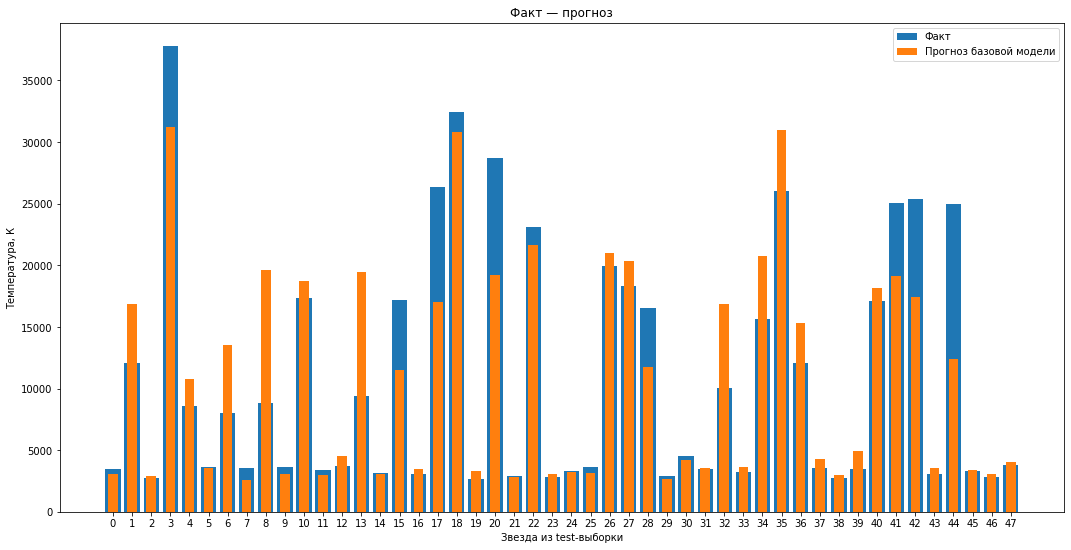

In [29]:
y1 = torch.FloatTensor(test_preds)
y1 = y1.detach().numpy().reshape([-1])
y2 = y_test.detach().numpy().reshape([-1])
x = np.arange(len(y1))

fig,ax = plt.subplots(figsize = (18, 9))
ax.set_xticks(x)
fact = ax.bar(x, y2, width = 0.8, label = 'Факт')
forecast = ax.bar(x, y1, width = 0.5, label = 'Прогноз базовой модели')
ax.legend()
ax.set_title('Факт — прогноз')
ax.set_xlabel('Звезда из test-выборки')
ax.set_ylabel('Температура, К');

**Вывод**
<br> Видно, что базовая модель уже укладывается в граничное значение RMSE = 4500. По графику видно, что наиболее точно описываются звезды с малой темппературой (до 5000 К). Для более горячих звезд идет больший разброс температуры, следовательно для НС труднее определять их температуру. Также сказывается то, что звезд с малой температурой в датасете мало.

## Улучшение нейронной сети

С целью улучшения неронной сети добавим Batch Normalization и Dropout.

In [30]:
# Новая сетка с Batchnorm и Dropout
class New_Net(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons, dropout):
            super(New_Net, self).__init__()
            
            self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
            self.act1 = nn.ReLU()
            self.bn1 = nn.BatchNorm1d(n_hidden_neurons_1)
            self.dp1 = nn.Dropout(p=dropout)
            self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
            self.act2 = nn.ReLU()
            self.fc3 = nn.Linear(n_hidden_neurons_2, n_out_neurons)
            
    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.bn1(x)
        x = self.dp1(x)        
        x = self.fc2(x)
        x = self.act2(x)       
        x = self.fc3(x)
        
        return x

In [31]:
# переберем dropout с 0,2 до 0,5
for dropout in [0.2, 0.3, 0.4, 0.5]:
    print('dropout = ', dropout)
    net = New_Net(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons, dropout)
    optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
    loss = nn.MSELoss()

    num_epochs = 10000
        
    for epoch in range(num_epochs):
        optimizer.zero_grad()
    
        preds = net.forward(X_train).flatten()
            
        loss_value = loss(preds, y_train)
        loss_value.backward()
            
        optimizer.step()
    
        if epoch % 1000 == 0 or epoch == num_epochs :
            net.eval()
            test_preds = net.forward(X_test).detach().numpy()
            RMSE = mean_squared_error(y_test, test_preds, squared=False)
            print(RMSE)
    print()

dropout =  0.2
14594.498
10038.694
6066.277
4974.632
4463.035
4541.5176
4472.754
4259.047
4051.603
3694.2322

dropout =  0.3
14594.46
8734.899
5609.7964
4625.475
4493.2866
4604.182
4579.2646
4527.9375
4463.4014
4399.717

dropout =  0.4
14594.687
9007.183
5710.8564
4692.8457
4471.0054
4598.2603
4570.076
4349.976
4079.2246
3825.8232

dropout =  0.5
14594.723
8397.551
5571.152
4582.974
4487.3823
4593.685
4483.4487
4168.9365
3914.0195
3671.3442



Как видно сильнее всего модель улучшает dropout = 0.3. Посмотрим, как на улучшение повлияет размер батча:

In [32]:
for batch in [50, 90]:
    print('batch_size = ', batch)
    new_net = New_Net(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons, 0.2)
    optimizer = torch.optim.Adam(new_net.parameters(), lr=1e-3)
    loss = nn.MSELoss()
    
    batch_size = batch
    num_epochs = 10000
    
    num_batches = ceil(len(X_train)/batch_size)
        
    for epoch in range(num_epochs):
    
        # случайная перестановка объектов
        order = np.random.permutation(len(X_train))
        
        for batch_idx in range(num_batches):
            start_index = batch_idx * batch_size
            optimizer.zero_grad()
    
            # получение индексов текущего батча
            batch_indexes = order[start_index:start_index+batch_size]
            X_batch = X_train[batch_indexes]
            y_batch = y_train[batch_indexes]    
        
        
            new_preds = new_net.forward(X_batch).flatten()
            
            loss_value = loss(new_preds, y_batch)
            loss_value.backward()
            
            optimizer.step()
    
        if epoch % 1000 == 0 or epoch == num_epochs :
            new_net.eval()
            new_test_preds = new_net.forward(X_test).detach().numpy()
            RMSE = mean_squared_error(y_test, new_test_preds, squared=False)
            print(RMSE)
    print()

batch_size =  50
14594.769
4551.2485
4606.833
4613.904
4582.9336
4553.6694
4523.2114
4490.346
4425.2627
4320.762

batch_size =  90
14594.579
5100.416
4488.535
4582.622
4607.5312
4576.5776
4529.9604
4446.5312
4285.9697
4121.0786



Как видно, регулирование размера батча не улучшает модель. Скорее всего это из-за того, что данный параметр вводится когда идёт обучение на больших датасетах, и не получается загрузить все нужные данные в оперативную память.

In [37]:
net = New_Net(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons, 0.2)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
loss = nn.MSELoss()

num_epochs = 10000
        
for epoch in range(num_epochs):
    optimizer.zero_grad()
    
    preds = net.forward(X_train).flatten()
            
    loss_value = loss(preds, y_train)
    loss_value.backward()
        
    optimizer.step()
    
    if epoch % 1000 == 0 or epoch == num_epochs :
        net.eval()
        test_preds = net.forward(X_test).detach().numpy()
        RMSE = mean_squared_error(y_test, test_preds, squared=False)
        print(RMSE)

14594.694
9674.103
5918.053
4851.8687
4448.9946
4576.804
4596.4756
4545.8887
4481.3853
4413.075


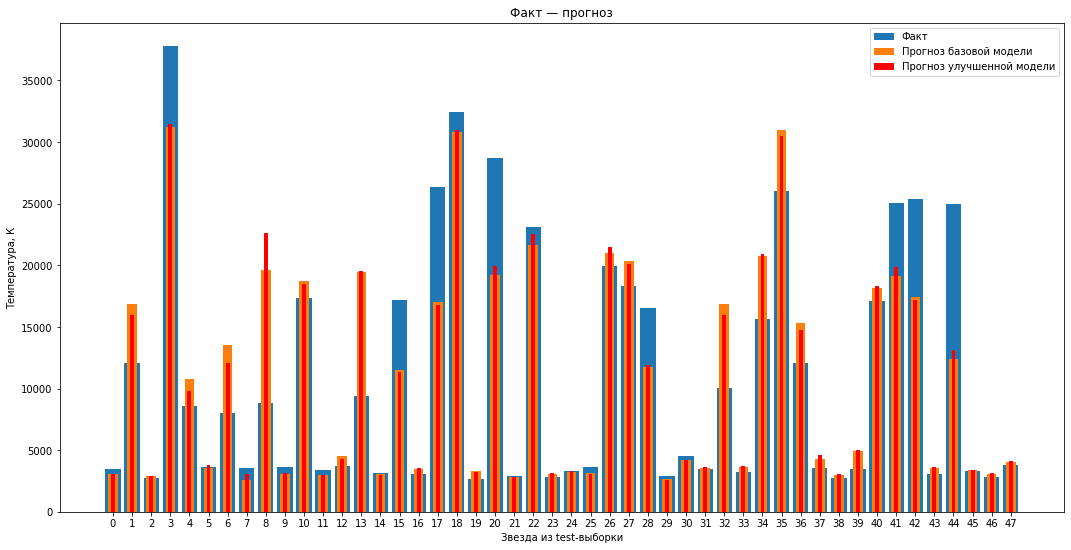

In [38]:
y3 = torch.FloatTensor(test_preds)
y3 = y3.detach().numpy().reshape([-1])
y2 = y_test.detach().numpy().reshape([-1])
x = np.arange(len(y3))

fig,ax = plt.subplots(figsize = (18, 9))
ax.set_xticks(x)
fact = ax.bar(x, y2, width = 0.8, label = 'Факт')
forecast = ax.bar(x, y1, width = 0.5, label = 'Прогноз базовой модели')
forecast_1 = ax.bar(x, y3, width = 0.2, color='red', label = 'Прогноз улучшенной модели')
ax.legend()
ax.set_title('Факт — прогноз')
ax.set_xlabel('Звезда из test-выборки')
ax.set_ylabel('Температура, К');

**Вывод**
<br>Улучшенная модель стала лучше предсказывать температуру горячих звезд. Размер батча сильно не улучшает модель. Наиболее оптимальным значением dropout можно считать 0,3.

## Выводы

Датасет содержит данные о 240 звездах. Пропуски / дубликаты отсутсвуют.
<br>Большинство звезд в датасете имеют температуру до 5000 К, а также довольно малую светимость и радиус относительно Солнца(< 1). Большинство звезд имеют красный, голубой и голубовато-белый цвет. Ввиду малого количества данных (всего 240 наблюдений) аномально высокие и низкие значения были оставлены. Наиболее сильно на температуру звезды влияют ее цвет и абсолютная звёздная величина. Из диаграмм рассеяния видно, что абсолютная звёздная величина мало влияет на температуру звезды.
<br>Построенная базовая модель уже укладывается в граничное значение RMSE = 4500. По графику видно, что наиболее точно описываются звезды с малой темппературой (до 5000 К). Для более горячих звезд идет больший разброс температуры, следовательно для НС труднее определять их температуру. Также сказывается то, что звезд с малой температурой в датасете мало.
<br>В результате добавления Batch Normalization и Dropout предсказательная способность модели улучшилась. Также стоит отметить, что RMSE ниже 4500 удалось достичь за меньшее количество эпох. По построенному графику видно, что улучшенная модель стала лучше предсказывать температуру горячих звезд. Размер батча сильно не улучшает модель. Наиболее оптимальным значением dropout можно считать 0,3.